### 1. Importing required modules

In [24]:
from __future__ import print_function

%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform as tf

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
import healpy

### 2. Fetching a HiPS tile

[[  6.12323400e-17  -1.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   6.12323400e-17   1.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
(149, 149)


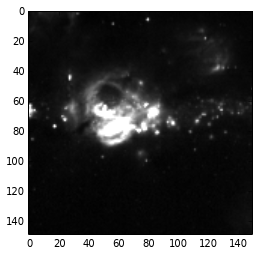

In [27]:
from astropy.utils.data import get_pkg_data_filename

tform = tf.SimilarityTransform(scale=1, rotation=math.pi/2,
                               translation=(0, 1))
print(tform.params)

# Get the all sky image
# hdu_list = fits.open('https://github.com/gammapy/gammapy-extra/blob/master/datasets/catalogs/fermi/gll_psch_v08.fit.gz?raw=true')
hdu_list = fits.open(get_pkg_data_filename('galactic_center/gc_msx_e.fits'))
# hdu_list = fits.open('https://rawgithub.com/hipspy/hips-extra/master/datasets/samples/DSS2Red/Norder3/Dir0/Npix448.fits')
wcs1 = WCS(hdu_list[0].header)
all_sky = hdu_list[0].data.astype('float')
print(all_sky.shape)
plt.imshow(all_sky, cmap='gray', vmax=0.0001)
plt.imsave(fname='all_sky.png', arr=all_sky, cmap='gray', vmax=0.0001)
plt.show()

### 3. Fetching the all sky image

In [3]:
tform = tf.SimilarityTransform(scale=1, rotation=math.pi/2,
                               translation=(0, 1))
# Get the all sky image
hdu_list = fits.open('https://github.com/gammapy/gammapy-extra/blob/master/datasets/catalogs/fermi/gll_psch_v08.fit.gz?raw=true')
wcs1 = WCS(hdu_list[0].header)
all_sky = hdu_list[0].data.astype('float')
print(hdu_list[0].data.shape)

(1800, 3600)


### 4. Applying Similarity Transform on the fetched HiPS tile

Filename: /home/adeel/.astropy/cache/download/py3/d3387fa3282ed3a583df0397a1bf0e2a
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       6   (512, 512)   int16   


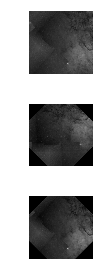

In [4]:
# hips_tile_hdu = fits.open('https://github.com/hipspy/hips-extra/blob/master/datasets/samples/DSS2Red/Norder3/Dir0/Npix450.fits?raw=true')
hips_tile_hdu = fits.open('https://rawgithub.com/hipspy/hips-extra/master/datasets/samples/DSS2Red/Norder3/Dir0/Npix448.fits')


hips_tile_hdu.info()
wcs = WCS(hips_tile_hdu[0].header)
data = hips_tile_hdu[0].data.astype('float')

text = data#.text()

# @todo: pass in the four corners of HiPS tile
tform = tf.SimilarityTransform(scale=1, rotation=math.pi/4,
                               translation=(text.shape[0]/2, -100))
rotated = tf.warp(text, tform)
back_rotated = tf.warp(rotated, tform.inverse)

fig, ax = plt.subplots(nrows=3)

ax[0].imshow(text, cmap=plt.cm.gray)
ax[1].imshow(rotated, cmap=plt.cm.gray)
ax[2].imshow(back_rotated, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

### 5. Computing tile boundaries using ``healpy.boundaries`` function

In [5]:
# Getting a new HiPS tile
nside = healpy.order2nside(order=3)
coords = healpy.boundaries(nside=nside, pix=377, nest=True)
theta, phi = healpy.vec2ang(np.transpose(coords), lonlat=False)
radec = SkyCoord(ra=phi, dec=np.pi/2 - theta, unit='radian', frame='icrs')
print(tuple(radec.icrs.data.lat.deg))
print(tuple(radec.icrs.data.lon.deg))

(24.624318352164074, 19.471220634490685, 14.477512185929921, 19.471220634490685)
(84.375, 78.75, 84.375, 90.0)


### 6. Function definition for computing HiPS tile corners

In [19]:
def compute_corners(order, ipix):
    nside = healpy.order2nside(order)
    coords = healpy.boundaries(nside, ipix, nest=True)
    theta, phi = healpy.vec2ang(np.transpose(coords), lonlat=False)
    radec = SkyCoord(ra=phi, dec=np.pi/2 - theta, unit='radian', frame='icrs')
    
    result = []
    for i in range(len(radec.ra.deg)):
        result.append([radec.ra.deg[i], radec.dec.deg[i]])
    return result

### 7. Function definition for drawing a  HiPS tile

In [22]:
from skimage import transform as tf

def draw_tile(warped, corners, out_shape, wcs):
    src = wcs.wcs_world2pix(corners, 0)
    print('Source : ', src)
    dst = np.array([[511, 0], [511, 511], [0, 511], [0, 0]])

    tform3 = tf.ProjectiveTransform()
    tform3.estimate(src, dst)
    return warped + tf.warp(text, tform3, output_shape=out_shape)

### 8. Calling the above functions and drawing HiPS tiles onto the all-sky image.
### The resulting image is shown below

(1800, 3600)
[[0.0, 9.5940682268604593], [354.375, 4.78019184719916], [0.0, 0.0], [5.625, 4.78019184719916]]
Source :  [[ 1799.5          995.32863541]
 [ 1855.59749199   947.30242808]
 [ 1799.5          899.5       ]
 [ 1743.40250801   947.30242808]]
[[90.0, 0.0], [84.375, -4.78019184719916], [90.0, -9.5940682268604593], [95.625, -4.78019184719916]]
Source :  [[ 922.45417744  899.5       ]
 [ 976.94121093  848.28646095]
 [ 932.20517888  795.83844171]
 [ 873.33840394  847.23641552]]
[[112.5, -9.5940682268604593], [106.875, -14.477512185929934], [112.5, -19.471220634490699], [118.125, -14.477512185929934]]
Source :  [[ 731.5783056   790.95020451]
 [ 795.82057691  738.17873336]
 [ 770.36051588  680.69720275]
 [ 699.78674445  733.97868107]]
[[90.0, 9.5940682268604593], [84.375, 4.78019184719916], [90.0, 0.0], [95.625, 4.78019184719916]]
Source :  [[  932.20517888  1003.16155829]
 [  976.94121093   950.71353905]
 [  922.45417744   899.5       ]
 [  873.33840394   951.76358448]]
[[180.0, 0.

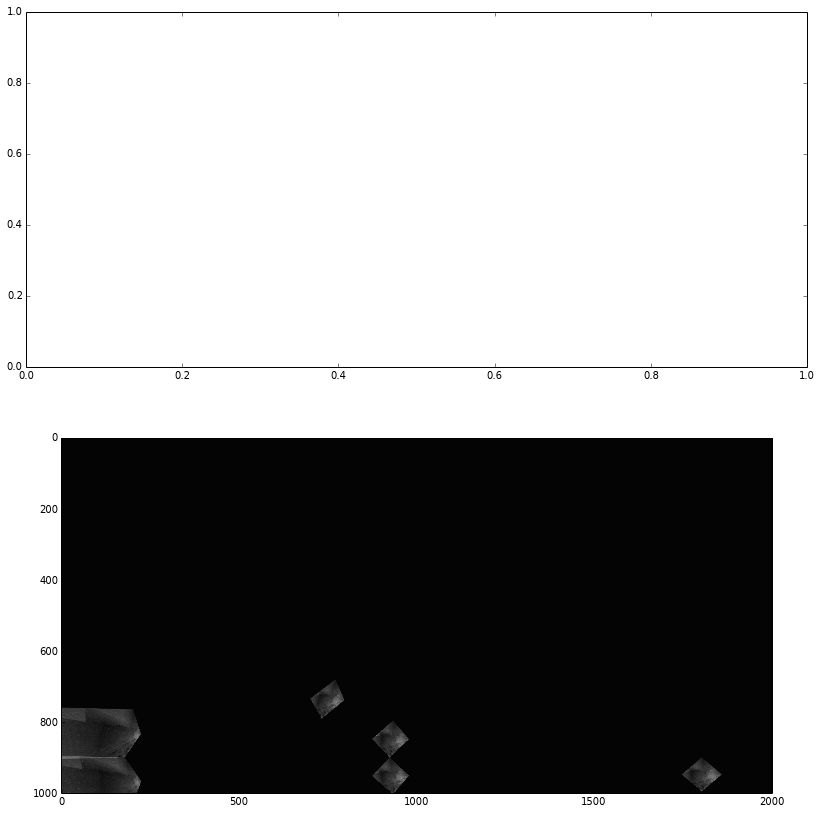

In [23]:
from astropy.visualization.wcsaxes import WCSAxes
import time
text = data
start = time.time()
warped = np.zeros((1000, 2000)) # the output image size
print(all_sky.shape)
# for i in range(0, 30):
#     corners = compute_corners(3, i)
#     warped = draw_tile(warped, corners, warped.shape, wcs1)
# HEALPix pixel indices: [304 335 336 368 399 400 432 463]
indices = [304, 335, 336, 368, 399, 400, 432, 463]
for index in indices:
    corners = compute_corners(3, index)
    print(corners)
    warped = draw_tile(warped, corners, warped.shape, wcs1)
print(warped)
fig, ax = plt.subplots(nrows=2, figsize=(14, 14))

# ax[0].imshow(all_sky, vmin=0, vmax=1, origin='upper', cmap=plt.cm.gray)
# ax[0].plot(src[:, 0], src[:, 1], '.r', )

ax[1].imshow(warped, origin='upper', cmap=plt.cm.gray)

end = time.time()
print(end - start)

### Applying swirl effect on the HiPS tile

/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:412: UserWarning: The default of `mode` in `skimage.transform.swirl` will change to `reflect` in version 0.15.
  warn('The default of `mode` in `skimage.transform.swirl` '


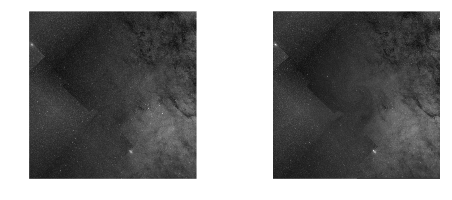

In [9]:
import matplotlib.pyplot as plt

# from skimage import data
from skimage.transform import swirl

data = np.array(data, dtype=float)
image = data#.checkerboard()
swirled = swirl(image, rotation=0, strength=10, radius=120)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3),
                               sharex=True, sharey=True,
                               subplot_kw={'adjustable':'box-forced'})

ax0.imshow(image, cmap=plt.cm.gray, interpolation='none')
ax0.axis('off')
ax1.imshow(swirled, cmap=plt.cm.gray, interpolation='none')
ax1.axis('off')

plt.show()

### Some other effects

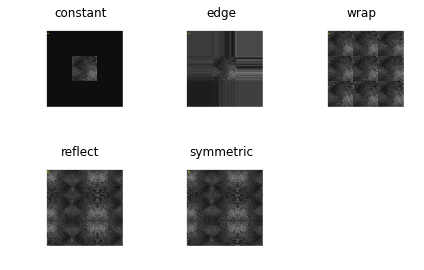

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.util import pad


img = data
img[:8, :8] += 1
img[:4, :4] += 1
img[:2, :2] += 1
img[:1, :1] += 2
img[8, 8] = 4

modes = ['constant', 'edge', 'wrap', 'reflect', 'symmetric']
fig, axes = plt.subplots(2, 3)
ax = axes.flatten()

for n, mode in enumerate(modes):
    img_padded = pad(img, pad_width=img.shape[0], mode=mode)
    ax[n].imshow(img_padded, cmap=plt.cm.gray, interpolation='nearest')
    ax[n].plot([15.5, 15.5, 31.5, 31.5, 15.5],
               [15.5, 31.5, 31.5, 15.5, 15.5], 'y--', linewidth=0.5)
    ax[n].set_title(mode)

for a in ax:
    a.set_axis_off()
    a.set_aspect('equal')

plt.tight_layout()
plt.show()

In [11]:
theta, phi = healpy.pix2ang(nside=8, ipix=[2,3])
vector = healpy.ang2vec(theta, phi)
vector
# nside7
y, x = np.indices(all_sky.shape)
# print(y, x)
dst = np.array([y, x])
lonlat = wcs1.all_pix2world(y, x, 0)
lonlat = np.array(lonlat)
# print(np.array(lonlat).shape)
pixels = healpy.query_disc(8, lonlat.flatten(), 900)

# nside = healpy.order2nside(order=3)
# coords = healpy.boundaries(nside=nside, pix=377, nest=True)
# theta, phi = healpy.vec2angg(np.transpose(coords), lonlat=False)
# radec = SkyCoord(ra=x, dec=np.pi/2 - y, unit='radian', frame='icrs')
import astropy
astropy.coordinates.angle_utilities.angular_separation(23, 20, 42, 12)
# astropy.separation(radec)

1.7207473751036122